In [1]:
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from utils import read_lastfm
from gensim.models import Word2Vec

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, make_scorer
from sklearn.dummy import DummyClassifier

In [3]:
songs, users = read_lastfm(zip_name="data/lastfm-dataset-1K.zip")

In [4]:
songs["song_id"]= songs.artist_name.cat.codes.astype("int64") * songs.track_name.nunique() \
                            + songs.track_name.cat.codes

# Song2vec loading

In [11]:
def build_vocab(model):
    emb_vectors = {}
    for n in model.wv.index_to_key:
        emb_vectors[n] = model.wv[n]
    return emb_vectors

def load_model(filename):
    model = Word2Vec.load(filename)
    emb_vectors = build_vocab(model)
    return emb_vectors, model

def get_embeddings(df, min_count=5):
    df = df.sort_values("timestamp")
    df = df[~df.track_name.isna()]
#     df["song_id"]= df.artist_name.cat.codes.astype("int64") * df.track_name.nunique() \
#                         + df.track_name.cat.codes
    print(f"Number of entries: {len(df)}")
    assert len(df.query("song_id < 0")) == 0 #Check underflow
    
    document = df.groupby("user_id").agg(sentences=("song_id", list))
    model = Word2Vec(document.sentences.values, **{'vector_size': 100, 'window': 3, 'min_count': 5, 'negative': 10, 'ns_exponent': 0})
    
    emb_vectors = build_vocab(model)
    print(f"Number of song embeddings: {len(emb_vectors)}")
    return df, emb_vectors, model

In [ ]:
users = songs.user_id.unique()
sample = songs[songs.user_id.isin(users)]
sample, emb_vectors, model = get_embeddings(sample)
model.save("data/word2vec/122.model")

Number of entries: 19098850


In [ ]:
# emb_vectors, model = load_model("data/word2vec/word2vec.model")
s2v_df = pd.DataFrame(data=emb_vectors.values(), index=emb_vectors.keys())

# TF-IDF initialization

In [5]:
corpus_df = songs.sort_values(["user_id", "timestamp"]).groupby("user_id")\
                .agg(sequence=("song_id", list))

In [6]:
corpus = corpus_df.values[:,0]

In [7]:
vectorizer = TfidfVectorizer(tokenizer=lambda x: x, lowercase=False)
X = vectorizer.fit_transform(corpus)

In [8]:
song_ids = list(vectorizer.vocabulary_.keys())
indices = list(vectorizer.vocabulary_.values())

In [9]:
song_ids = [x for _,x in sorted(zip(indices,song_ids))]

In [10]:
tfidf_df = pd.DataFrame(data=X.T.todense(), index=song_ids)

# Classification Tasks

* Predict if two songs appear in the same context
* Predict if two songs are from the same artist
* Predict the artist of a song
* Predict the tag of a song

In [ ]:
SEED = 42

In [ ]:
def compute_metrics(y_test, y_pred, y_proba, multi=False):
    acc = accuracy_score(y_test, y_pred)
    if not multi:
        f1 = f1_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_proba)
        return acc, f1, auc
    else:
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        cm = confusion_matrix(y_test, y_pred)
        return acc, f1, cm

In [ ]:
def predict_RF(X_train, X_test, y_train, y_test, scoring='f1', multi=False,
               param_grid = {'n_estimators': [2,100, 150, 200, 300],
                      'criterion': ['gini', 'entropy']}):    
    model = RandomForestClassifier(random_state=SEED)
    cv = KFold(n_splits=5, shuffle=True, random_state=SEED)
    grid = GridSearchCV(model, param_grid, cv=cv, scoring=scorer, verbose=4)
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_
    print(f"Best parameters are: {grid.best_params_}")
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:,1]
    return compute_metrics(y_test, y_pred, y_proba, multi=multi)


In [ ]:
def predict_random(X_train, y_train, X_test, y_test, multi=False):
    random = DummyClassifier(strategy='uniform', random_state=SEED)
    random.fit(X_train, y_train)
    y_pred = random.predict(X_test)
    y_proba = random.predict_proba(X_test)[:, 1]
    return compute_metrics(y_test, y_pred, y_proba, multi=multi)

def predict_majority(X_train, y_train, X_test, y_test, multi=False):
    majority = DummyClassifier(strategy='most_frequent', random_state=SEED)
    majority.fit(X_train, y_train)
    y_pred = majority.predict(X_test)
    y_proba = majority.predict_proba(X_test)[:, 1]
    return compute_metrics(y_test, y_pred, y_proba, multi=multi)

In [ ]:
def create_vectors_pairs(vectors, song_pairs):
    vector_pairs = vectors.merge(song_pairs, right_on="song1", left_index=True)\
            .merge(vectors, left_on="song2", right_index=True)\
            .drop(['song1', 'song2'], axis=1)
    print(len(vector_pairs))
    print(len(song_pairs))
    assert len(vector_pairs) == len(song_pairs)
    assert vector_pairs.shape[1] == vectors.shape[1] * 2
    return vector_pairs

## Same context classification

In [ ]:
sorted_songs = songs.sort_values(["user_id", "timestamp"])

In [ ]:
def pick_song_in_same_context(songs, half_n):
    """Simply chooses random songs pair them with the previous or following one"""
    np.random.seed(SEED)
    idx1 = np.random.randint(1, len(songs) - 1, half_n) #Exclude first and last song
    idx2 = idx1.copy() #Offset the first index by -1 or 1 
    idx2[::2] += 1
    idx2[1::2] -= 1
    songs1 = songs.iloc[idx1].song_id.values
    songs2 = songs.iloc[idx2].song_id.values
    X = np.c_[songs1, songs2]
    y = np.ones(half_n)
    return X, y
    
def pick_songs_in_diff_context(songs, half_n):
    songs1 = songs.sample(half_n, random_state=SEED).song_id.values
    songs2 = songs.sample(half_n, random_state=SEED + 1).song_id.values
    X = np.c_[songs1, songs2]
    y = np.zeros(half_n)
    return X, y

def create_context_dataset(sorted_songs, n=20000):
    """Create a dataset of song pairs that either appeared in the same context or not""" 
    X_pos, y_pos = pick_song_in_same_context(sorted_songs, n//2)
    X_neg, y_neg = pick_songs_in_diff_context(sorted_songs, n//2)
    old_X = np.r_[X_pos, X_neg]
    old_y = np.r_[y_pos, y_neg]
    dataset = list(zip(old_X, old_y))
    np.random.seed(SEED)
    np.random.shuffle(dataset)
    X, y = zip(*dataset)
    return pd.DataFrame(X, columns=["song1", "song2"]), np.array(y)

In [ ]:
song_pairs, labels = create_context_dataset(sorted_songs, n= 10000)

In [ ]:
#Only keep song with s2v embeddings
song_pairs = song_pairs.copy()
song_pairs['labels'] = labels
song_pairs = song_pairs[song_pairs.song1.isin(s2v_df.index) & song_pairs.song2.isin(s2v_df.index)]
labels = song_pairs.labels
song_pairs.drop('labels', axis=1, inplace=True)

### TF-IDF

In [ ]:
tfidf_pairs = create_vectors_pairs(tfidf_df, song_pairs)

In [ ]:
tfidf_pairs.head()

In [ ]:
X_train, X_test, y_train, y_test = \
                train_test_split(tfidf_pairs, labels, train_size=0.8, random_state=SEED)
acc, f1, auc = predict_RF(X_train, X_test, y_train, y_test)

In [ ]:
print("TF-IDF:", acc, f1, auc)
print("Random:", predict_random(X_train, y_train, X_test, y_test))
print("Majority:",predict_majority(X_train, y_train, X_test, y_test))

### song2vec

In [ ]:
s2v_pairs = create_vectors_pairs(s2v_df, song_pairs)

In [ ]:
s2v_pairs.head()

In [ ]:
X_train, X_test, y_train, y_test = \
                train_test_split(s2v_pairs, labels, train_size=0.8, random_state=SEED)
acc, f1, auc = predict_RF(X_train, X_test, y_train, y_test)

In [ ]:
print("Song2Vec:", acc, f1, auc)

## Same artist classification

In [ ]:
discography = songs[["artist_name", "track_name", "song_id"]].drop_duplicates()

In [ ]:
def pick_songs_from_same_artist(discography, half_n):
    """Simply chooses random songs pair them with the previous or following one"""
    artist_with_multiple_songs = discography.groupby("artist_name")\
                                .agg(count=("track_name", "count")).reset_index()
    discography = discography.merge(artist_with_multiple_songs)
    
    song_pairs = discography.groupby("artist_name").agg(song1=("song_id", "first"), 
                                                        song2=("song_id", "last"))
    X = song_pairs.sample(half_n, random_state=SEED).values
    y = np.ones(half_n)
    return X, y
    
def pick_songs_from_diff_artist(discography, half_n):
    discography = discography.drop_duplicates("artist_name")
    songs = discography.sample(2*half_n, random_state=SEED).song_id.values
    songs1 = songs[:half_n]
    songs2 = songs[half_n:]
    X = np.c_[songs1, songs2]
    y = np.zeros(half_n)
    return X, y

def create_artist_dataset(discography, n=20000):
    """Create a dataset of song pairs that either appeared in the same context or not""" 
    discography = discography.merge(s2v_df, left_on="song_id", right_index=True)
    discography = discography.merge(tfidf_df, left_on="song_id", right_index=True)
    X_pos, y_pos = pick_songs_from_same_artist(discography, n//2)
    X_neg, y_neg = pick_songs_from_diff_artist(discography, n//2)
    old_X = np.r_[X_pos, X_neg]
    old_y = np.r_[y_pos, y_neg]
    dataset = list(zip(old_X, old_y))
    np.random.seed(SEED)
    np.random.shuffle(dataset)
    X, y = zip(*dataset)
    return pd.DataFrame(X, columns=["song1", "song2"]), np.array(y)

In [ ]:
song_pairs, labels = create_artist_dataset(discography, 20000)

In [ ]:
#Only keep song with s2v embeddings
song_pairs = song_pairs.copy()
song_pairs['labels'] = labels
song_pairs = song_pairs[song_pairs.song1.isin(s2v_df.index) & song_pairs.song2.isin(s2v_df.index)]
song_pairs = song_pairs[song_pairs.song1.isin(tfidf_df.index) & song_pairs.song2.isin(tfidf_df.index)]
labels = song_pairs.labels
# song_pairs.drop('labels', axis=1, inplace=True)

In [ ]:
song_pairs_neg = song_pairs.query("labels == 0").iloc[:3547]
song_pairs_pos = song_pairs.query("labels == 1")

In [ ]:
song_pairs = pd.concat([song_pairs_neg, song_pairs_pos])
labels = song_pairs.labels
song_pairs.drop('labels', axis=1, inplace=True)

### TF-IDF

In [ ]:
tfidf_pairs = create_vectors_pairs(tfidf_df, song_pairs)

In [ ]:
X_train, X_test, y_train, y_test = \
                train_test_split(tfidf_pairs, labels, train_size=0.8, random_state=SEED)

In [ ]:
X_train, X_test, y_train, y_test = \
                train_test_split(tfidf_pairs, labels, train_size=0.8, random_state=SEED)
acc, f1, auc = predict_RF(X_train, X_test, y_train, y_test)

In [ ]:
print("TF-IDF:", acc, f1, auc)

### Song2vec

In [ ]:
s2v_pairs = create_vectors_pairs(s2v_df, song_pairs)

In [ ]:
X_train, X_test, y_train, y_test = \
                train_test_split(s2v_pairs, labels, train_size=0.8, random_state=SEED)
acc, f1, auc = predict_RF(X_train, X_test, y_train, y_test)

In [55]:
print("Song2Vec:", acc, f1, auc)

Song2Vec: 0.6645525017618041 0.7203290246768507 0.7202693033886515


In [56]:
print("Random:", predict_random(X_train, y_train, X_test, y_test))
print("Majority:",predict_majority(X_train, y_train, X_test, y_test))

Random: (0.5088090204369274, 0.503914590747331, 0.5)
Majority: (0.48907681465821, 0.6568859441552295, 0.5)


## Top artists classification

In [83]:
def create_top_artist_dataset(df, top_n=10):
    top_artist = df[df.song_id.isin(emb_vectors.keys())].artist_name.value_counts()\
        .to_frame().head(top_n).index
    top_artist_codes = list(top_artist.codes)
    top_artist = list(top_artist)
    top_df = songs[songs.artist_name.cat.codes.isin(top_artist_codes)].drop_duplicates('song_id').copy()
    mapping = {artist: top_artist.index(artist) for artist in top_artist}
    top_df['label'] = top_df.artist_name.map(mapping)
    top_df = top_df[['song_id', 'label']]
    top_df = top_df[top_df.song_id.isin(s2v_df.index) & top_df.song_id.isin(tfidf_df.index)]
    return top_df

In [96]:
top_artist_songs = create_top_artist_dataset(songs, top_n=30)

In [97]:
len(top_artist_songs)

9283

In [190]:
param_grid = {'n_estimators': [150, 200, 300],
              'criterion': ['gini', 'entropy'],
              'class_weight':['balanced']
             }
scorer = make_scorer(f1_score, average='weighted')

### TF-IDF

In [104]:
tfidf_top_artist = tfidf_df.merge(top_artist_songs, left_index=True, right_on='song_id')
assert len(top_artist_songs) == len(tfidf_top_artist)
X_tfidf = tfidf_top_artist.drop(['song_id', 'label'], axis=1)
y_tfidf = tfidf_top_artist.label.values.astype(int)

In [191]:
X_train, X_test, y_train, y_test = \
                train_test_split(X_tfidf, y_tfidf, train_size=0.8, random_state=SEED)

acc, f1, cm = predict_RF(X_train, X_test, y_train, y_test, param_grid=param_grid, scoring=scorer, multi=True)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END class_weight=balanced, criterion=gini, n_estimators=150; total time=   8.4s
[CV 2/5] END class_weight=balanced, criterion=gini, n_estimators=150; total time=   8.1s
[CV 3/5] END class_weight=balanced, criterion=gini, n_estimators=150; total time=   8.2s
[CV 4/5] END class_weight=balanced, criterion=gini, n_estimators=150; total time=   8.1s
[CV 5/5] END class_weight=balanced, criterion=gini, n_estimators=150; total time=   8.2s
[CV 1/5] END class_weight=balanced, criterion=gini, n_estimators=200; total time=  10.9s
[CV 2/5] END class_weight=balanced, criterion=gini, n_estimators=200; total time=  10.9s
[CV 3/5] END class_weight=balanced, criterion=gini, n_estimators=200; total time=  11.0s
[CV 4/5] END class_weight=balanced, criterion=gini, n_estimators=200; total time=  10.8s
[CV 5/5] END class_weight=balanced, criterion=gini, n_estimators=200; total time=  10.9s
[CV 1/5] END class_weight=balanced, criterion=gini

In [192]:
print("TF-IDF:", acc, f1)

TF-IDF: 0.8152934841141626 0.8153098656342951


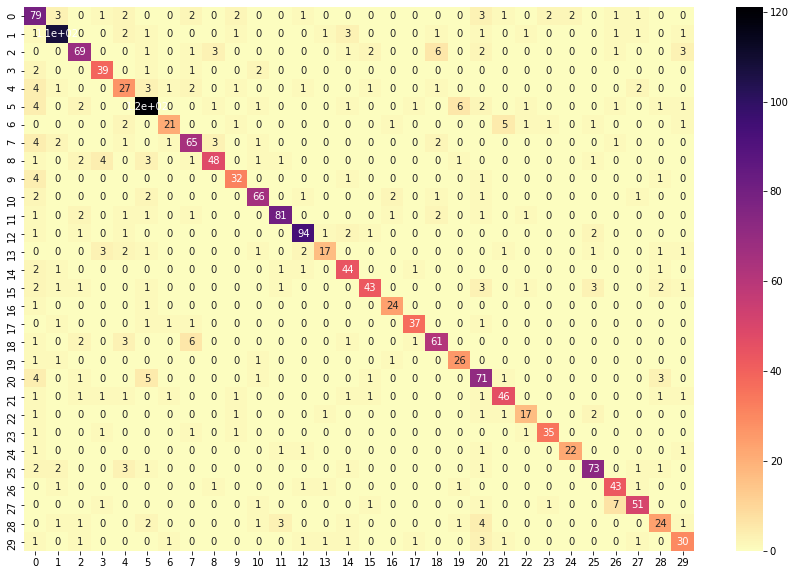

In [193]:
plt.figure(figsize=(15,10))
sns.heatmap(data=cm, cmap='magma_r', annot=True);

### Song2Vec

In [184]:
s2v_top_artist = s2v_df.merge(top_artist_songs, left_index=True, right_on='song_id')
assert len(top_artist_songs) == len(s2v_top_artist)
X_s2v = s2v_top_artist.drop(['song_id', 'label'], axis=1)
y_s2v = s2v_top_artist.label.values.astype(int)

In [194]:
X_train, X_test, y_train, y_test = \
                train_test_split(X_s2v, y_s2v, train_size=0.8, random_state=SEED)
acc, f1, cm = predict_RF(X_train, X_test, y_train, y_test, param_grid=param_grid, scoring=scorer,multi=True)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END class_weight=balanced, criterion=gini, n_estimators=150; total time=  13.1s
[CV 2/5] END class_weight=balanced, criterion=gini, n_estimators=150; total time=  14.8s
[CV 3/5] END class_weight=balanced, criterion=gini, n_estimators=150; total time=  12.5s
[CV 4/5] END class_weight=balanced, criterion=gini, n_estimators=150; total time=  12.1s
[CV 5/5] END class_weight=balanced, criterion=gini, n_estimators=150; total time=  11.9s
[CV 1/5] END class_weight=balanced, criterion=gini, n_estimators=200; total time=  15.8s
[CV 2/5] END class_weight=balanced, criterion=gini, n_estimators=200; total time=  17.8s
[CV 3/5] END class_weight=balanced, criterion=gini, n_estimators=200; total time=  17.0s
[CV 4/5] END class_weight=balanced, criterion=gini, n_estimators=200; total time=  15.9s
[CV 5/5] END class_weight=balanced, criterion=gini, n_estimators=200; total time=  16.0s
[CV 1/5] END class_weight=balanced, criterion=gini

In [195]:
print("Song2Vec:", acc, f1)

Song2Vec: 0.7436725901992461 0.7578103246040926


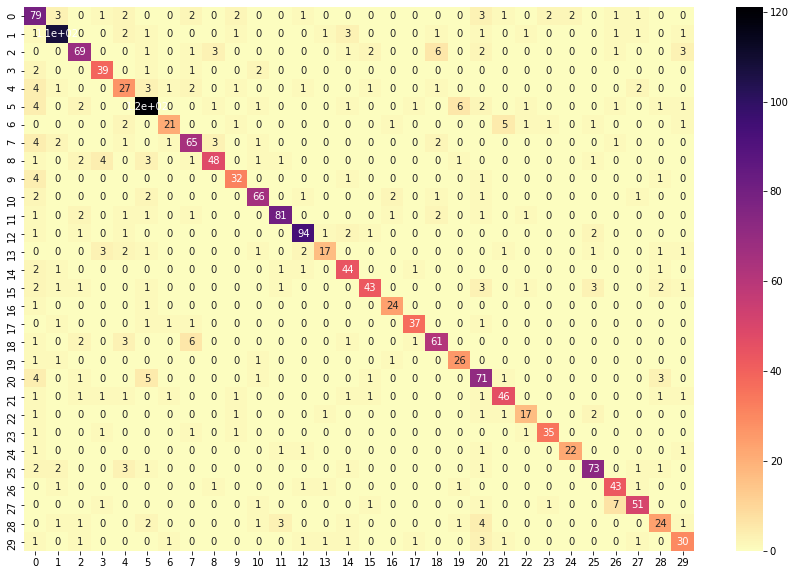

In [196]:
plt.figure(figsize=(15,10))
sns.heatmap(data=cm, cmap='magma_r', annot=True);

In [197]:
print("Random:", predict_random(X_train, y_train, X_test, y_test, multi=True)[:2])
print("Majority:",predict_majority(X_train, y_train, X_test, y_test, multi=True)[:2])

Random: (0.033925686591276254, 0.03561354992190356)
Majority: (0.07162089391491654, 0.00957344612129035)


## Top tag 

In [17]:
top_tags = pd.read_csv("data/song_tags_top1.csv")
songs = songs.merge(top_tags, how='left')

In [18]:
len(songs)

19098862

In [19]:
def create_top_tag_dataset(df, top_n=10):
    top_tags = list(df[df.song_id.isin(emb_vectors.keys())].tag_1.value_counts()\
        .to_frame().head(top_n).index)
    top_df = songs[songs.tag_1.isin(top_tags)].drop_duplicates('song_id').copy()
    mapping = {tag: top_tags.index(tag) for tag in top_tags}
    top_df['label'] = top_df.tag_1.map(mapping)
    top_df = top_df[['song_id', 'label']]
    top_df = top_df[top_df.song_id.isin(s2v_df.index) & top_df.song_id.isin(tfidf_df.index)]
    return top_df

In [21]:
top_tag_songs = create_top_tag_dataset(songs, top_n=10).iloc[:10000]
len(top_tag_songs)

10000

In [22]:
param_grid = {'n_estimators': [2, 100, 200, 300],
              'criterion': ['gini', 'entropy'],
              'class_weight':['balanced']
             }
scorer = make_scorer(f1_score, average='weighted')

### TF-IDF

In [23]:
tfidf_top_tag = tfidf_df.merge(top_tag_songs, left_index=True, right_on='song_id')
assert len(top_tag_songs) == len(tfidf_top_tag)
X_tfidf = tfidf_top_tag.drop(['song_id', 'label'], axis=1)
y_tfidf = tfidf_top_tag.label.values.astype(int)

In [24]:
X_train, X_test, y_train, y_test = \
                train_test_split(X_tfidf, y_tfidf, train_size=0.8, random_state=SEED)

acc, f1, cm = predict_RF(X_train, X_test, y_train, y_test, param_grid=param_grid, scoring=scorer, multi=True)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END class_weight=balanced, criterion=gini, n_estimators=2; total time=   0.3s
[CV 2/5] END class_weight=balanced, criterion=gini, n_estimators=2; total time=   1.0s
[CV 3/5] END class_weight=balanced, criterion=gini, n_estimators=2; total time=   0.2s
[CV 4/5] END class_weight=balanced, criterion=gini, n_estimators=2; total time=   0.2s
[CV 5/5] END class_weight=balanced, criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END class_weight=balanced, criterion=gini, n_estimators=100; total time=   4.5s
[CV 2/5] END class_weight=balanced, criterion=gini, n_estimators=100; total time=   4.6s
[CV 3/5] END class_weight=balanced, criterion=gini, n_estimators=100; total time=   4.4s
[CV 4/5] END class_weight=balanced, criterion=gini, n_estimators=100; total time=   4.4s
[CV 5/5] END class_weight=balanced, criterion=gini, n_estimators=100; total time=   4.5s
[CV 1/5] END class_weight=balanced, criterion=gini, n_estima

In [25]:
print("TF-IDF:", acc, f1)

TF-IDF: 0.7545 0.7443135699045567


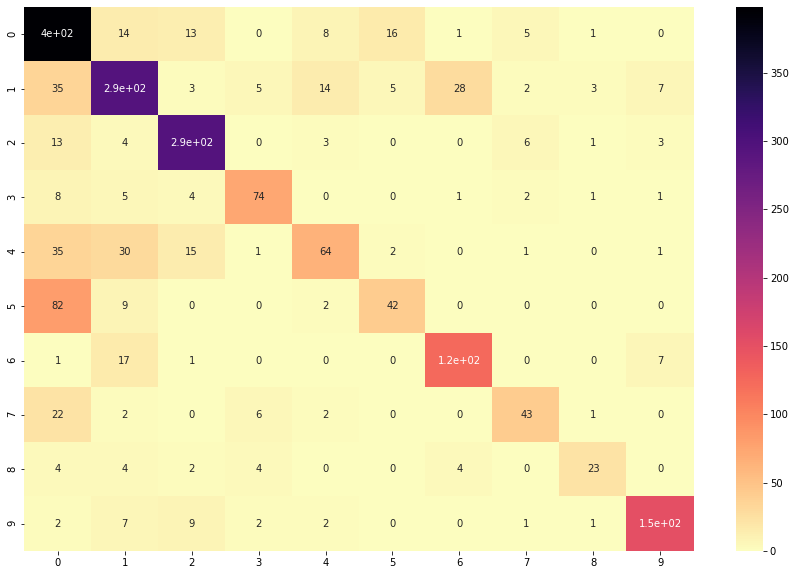

In [26]:
plt.figure(figsize=(15,10))
sns.heatmap(data=cm, cmap='magma_r', annot=True);

### Song2Vec

In [27]:
s2v_top_tag = s2v_df.merge(top_tag_songs, left_index=True, right_on='song_id')
assert len(top_tag_songs) == len(s2v_top_tag)
X_s2v = s2v_top_tag.drop(['song_id', 'label'], axis=1)
y_s2v = s2v_top_tag.label.values.astype(int)

In [28]:
X_train, X_test, y_train, y_test = \
                train_test_split(X_s2v, y_s2v, train_size=0.8, random_state=SEED)
acc, f1, cm = predict_RF(X_train, X_test, y_train, y_test, param_grid=param_grid, scoring=scorer,multi=True)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END class_weight=balanced, criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END class_weight=balanced, criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END class_weight=balanced, criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END class_weight=balanced, criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END class_weight=balanced, criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END class_weight=balanced, criterion=gini, n_estimators=100; total time=   5.7s
[CV 2/5] END class_weight=balanced, criterion=gini, n_estimators=100; total time=   5.6s
[CV 3/5] END class_weight=balanced, criterion=gini, n_estimators=100; total time=   5.7s
[CV 4/5] END class_weight=balanced, criterion=gini, n_estimators=100; total time=   5.7s
[CV 5/5] END class_weight=balanced, criterion=gini, n_estimators=100; total time=   5.7s
[CV 1/5] END class_weight=balanced, criterion=gini, n_estima

In [29]:
print("Song2Vec:", acc, f1)

Song2Vec: 0.6305 0.6100534611070575


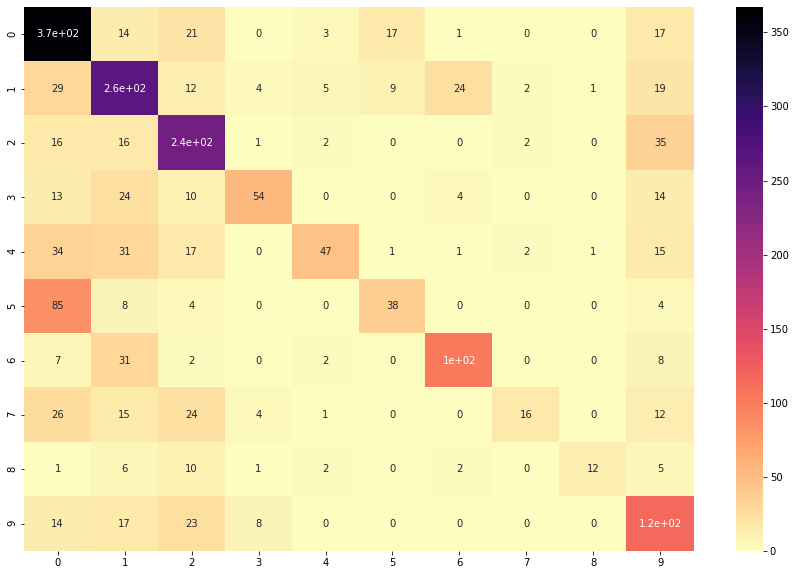

In [32]:
plt.figure(figsize=(15,10))
sns.heatmap(data=auc, cmap='magma_r', annot=True);

In [31]:
print("Random:", predict_random(X_train, y_train, X_test, y_test, multi=True)[:2])
print("Majority:",predict_majority(X_train, y_train, X_test, y_test, multi=True)[:2])

Random: (0.0965, 0.10629521826890108)
Majority: (0.22, 0.07934426229508197)
